## Preprocess data

First read data from directory. After reading data, convert the categorical column into numerical values that can be put into neural network.

Using 'glob' package we can read data files containing specific characters. 

In [1]:
import pandas as pd

In [2]:
path = "D:/rfiles/feature_matrix/feature_matrix_time_1024_outer_6.csv"
df = pd.read_csv(path)
df.head()

,max,min,mean,sd,rms,skewness,kurtosis,crest,form,fault_type
0,0.21779,-0.19860,0.012421,0.074997,0.075982,-0.162737,-0.249050,2.866329,6.117247,Normal
1,0.21216,-0.27287,0.011589,0.069499,0.070425,-0.107232,0.178607,3.012546,6.076971,Normal
2,0.21237,-0.20820,0.014643,0.077034,0.078377,0.050254,-0.381294,2.709611,5.352335,Normal
3,0.22301,-0.22676,0.010937,0.078972,0.079688,-0.163349,-0.040365,2.798539,7.286094,Normal
4,0.18859,-0.18692,0.013359,0.074959,0.076104,-0.028402,-0.326834,2.478067,5.696816,Normal


Now we will read the first files and use it in further analysis. 

In [3]:
df["fault_type"].value_counts()

Normal        1657
0.021 inch     476
0.007 inch     475
0.014 inch     474
Name: fault_type, dtype: int64

Now we will split the total data into training and test set. The dataset is unbalanced (it has more normal data as compared to other faulty data types). So first we create a balanced dataset and then form a training and test set.

In [4]:
import numpy as np
from numpy.random import choice 
np.random.seed(1)
index = np.array([choice(np.arange(0,1657),450,replace = False),
                choice(np.arange(1657,2132),450,replace = False),
                choice(np.arange(2132,2606),450,replace = False),
                choice(np.arange(2606,3082),450,replace = False)])
index = index.ravel()
data = df.iloc[index,]
data = data.reset_index(drop = True)
test_index = np.array([choice(np.arange(0,450),150, replace = False),
                     choice(np.arange(450,2*450),150, replace = False),
                     choice(np.arange(2*450,3*450),150, replace = False),
                     choice(np.arange(3*450,4*450),150, replace = False)])
test_index = test_index.ravel()
test_data = data.iloc[test_index,]
train_data = data.drop(data.index[test_index])

# Shuffle data
train_data = train_data.sample(frac = 1, random_state = 2)
test_data = test_data.sample(frac = 1, random_state = 3)

# Convert categorical lables to numberic entries

category_labels = ['Normal', '0.007 inch', '0.014 inch','0.021 inch']
# test_labels = test_data['fault_type']
test_labels = pd.Categorical(test_data['fault_type'],categories= category_labels).codes # Produces ndarrays
# train_labels = train_data['fault_type']
train_labels = pd.Categorical(train_data['fault_type'], categories = category_labels).codes

In [5]:
print(data.shape,test_data.shape,train_data.shape,test_labels.shape,train_labels.shape)

(1800, 10) (600, 10) (1200, 10) (600,) (1200,)


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import sklearn
from sklearn import preprocessing

In [7]:
# Convert labels to categorical data
train_data = train_data.iloc[:,0:9]
test_data = test_data.iloc[:,0:9]
# Scale the data
train_data = preprocessing.scale(train_data)
test_data = preprocessing.scale(test_data)
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [8]:
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)

(1200, 9) (600, 9) (1200, 4) (600, 4)


In [13]:
model = Sequential([
    layers.Dense(5,activation = 'relu', input_dim = 9),
    layers.Dense(4,activation = 'softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 5)                 50        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 24        
Total params: 74
Trainable params: 74
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [15]:
callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)]

In [16]:
history = model.fit(train_data,train_labels,epochs = 100, validation_split = 0.2, verbose = 2,callbacks = callbacks)

Train on 960 samples, validate on 240 samples
Epoch 1/100
960/960 - 0s - loss: 1.7510 - accuracy: 0.1625 - val_loss: 1.6559 - val_accuracy: 0.1875
Epoch 2/100
960/960 - 0s - loss: 1.5405 - accuracy: 0.1729 - val_loss: 1.4695 - val_accuracy: 0.2000
Epoch 3/100
960/960 - 0s - loss: 1.3996 - accuracy: 0.2062 - val_loss: 1.3454 - val_accuracy: 0.2542
Epoch 4/100
960/960 - 0s - loss: 1.3034 - accuracy: 0.2844 - val_loss: 1.2513 - val_accuracy: 0.3542
Epoch 5/100
960/960 - 0s - loss: 1.2288 - accuracy: 0.3854 - val_loss: 1.1746 - val_accuracy: 0.4625
Epoch 6/100
960/960 - 0s - loss: 1.1683 - accuracy: 0.4500 - val_loss: 1.1121 - val_accuracy: 0.4958
Epoch 7/100
960/960 - 0s - loss: 1.1170 - accuracy: 0.5208 - val_loss: 1.0575 - val_accuracy: 0.5875
Epoch 8/100
960/960 - 0s - loss: 1.0727 - accuracy: 0.5885 - val_loss: 1.0126 - val_accuracy: 0.6458
Epoch 9/100
960/960 - 0s - loss: 1.0334 - accuracy: 0.6531 - val_loss: 0.9755 - val_accuracy: 0.6792
Epoch 10/100
960/960 - 0s - loss: 0.9976 - ac

Epoch 81/100
960/960 - 0s - loss: 0.1986 - accuracy: 0.9312 - val_loss: 0.1998 - val_accuracy: 0.9167
Epoch 82/100
960/960 - 0s - loss: 0.1979 - accuracy: 0.9281 - val_loss: 0.1986 - val_accuracy: 0.9167
Epoch 83/100
960/960 - 0s - loss: 0.1967 - accuracy: 0.9302 - val_loss: 0.1976 - val_accuracy: 0.9167
Epoch 84/100
960/960 - 0s - loss: 0.1959 - accuracy: 0.9281 - val_loss: 0.1963 - val_accuracy: 0.9167
Epoch 85/100
960/960 - 0s - loss: 0.1946 - accuracy: 0.9281 - val_loss: 0.1953 - val_accuracy: 0.9167
Epoch 86/100
960/960 - 0s - loss: 0.1938 - accuracy: 0.9281 - val_loss: 0.1944 - val_accuracy: 0.9167
Epoch 87/100
960/960 - 0s - loss: 0.1929 - accuracy: 0.9292 - val_loss: 0.1933 - val_accuracy: 0.9167
Epoch 88/100
960/960 - 0s - loss: 0.1921 - accuracy: 0.9292 - val_loss: 0.1923 - val_accuracy: 0.9167
Epoch 89/100
960/960 - 0s - loss: 0.1913 - accuracy: 0.9292 - val_loss: 0.1914 - val_accuracy: 0.9167
Epoch 90/100
960/960 - 0s - loss: 0.1904 - accuracy: 0.9281 - val_loss: 0.1904 - v

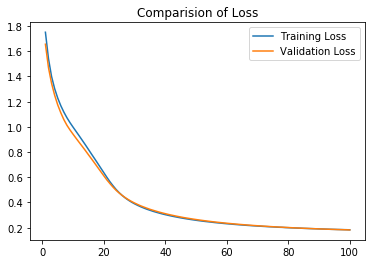

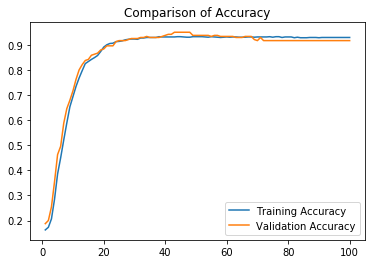

In [18]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = np.arange(1,len(train_loss)+1)
plt.figure()
plt.plot(epochs, train_loss, label = "Training Loss")
plt.plot(epochs, val_loss, label = "Validation Loss")
plt.legend()
plt.title("Comparision of Loss")
plt.show()
plt.figure()
plt.plot(epochs, train_acc, label = "Training Accuracy")
plt.plot(epochs, val_acc, label = "Validation Accuracy")
plt.title("Comparison of Accuracy")
plt.legend()
plt.show()

In [19]:
test_loss,test_acc = model.evaluate(test_data, test_labels)

600/600 [==============================] - 0s 32us/sample - loss: 0.1805 - accuracy: 0.9450


In [20]:
print(test_acc)

0.945


In [21]:
prediction = model.predict(test_data)
prediction_labels = list([])
for each_prediction in prediction:
    prediction_labels.append(list(each_prediction).index(max(each_prediction)))
    

In [22]:
from sklearn.metrics import confusion_matrix
true_labels = np.argmax(test_labels, axis = 1)
matrix = confusion_matrix(true_labels, prediction_labels)

(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text xticklabel objects>)

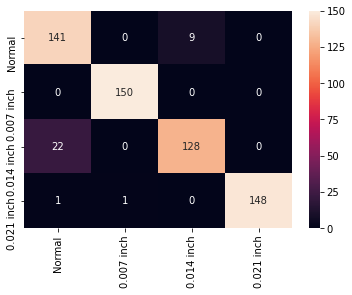

In [23]:
import seaborn as sns
matrix = pd.DataFrame(matrix)
sns.heatmap(matrix, annot= True, fmt = "d",
           xticklabels = category_labels,
           yticklabels = category_labels)
plt.xticks(rotation = 90)